This project implements the **Medallion Architecture** with **Unity Catalog integration**:

```
Data Sources → Object Storage →  Bronze →  Silver →  Gold → Consumption Layer
(Apple Health)   (Workspace)    (Delta)    (Delta)    (Delta)  (Analytics/ML)
```

### Architecture Components We'll Build:
- ** Data Sources**: Apple Health XML exports (600K+ records)
- ** Object Storage**: Databricks workspace file system  
- ** Delta Tables**: ACID transactions across Bronze/Silver/Gold layers
- ** Unity Catalog**: Centralized metadata and governance (3-level namespace)
- ** Consumption Layer**: Data Marts, Analytics, ML-ready features

### Why this matters:
Same patterns used by **Netflix**, **Spotify**, **Airbnb** for processing billions of records

### Why Your Apple Health Data Needs a Lakehouse:
- **Variety**: XML, JSON, time series data
- **Volume**: Years of minute-by-minute measurements  
- **Schema Evolution**: Apple adds new health metrics over time
Due to high volume and variety of data, Apple health needs a datalake to store unstructured data

## 🏛️ Setup Unity Catalog Structure

Unity Catalog provides a 3-level namespace (catalog.schema.table) for organizing and securing data assets.




In [0]:
%sql
-- Unity Catalog Setup
CREATE CATALOG IF NOT EXISTS health_data;
CREATE SCHEMA IF NOT EXISTS health_data.bronze;
CREATE SCHEMA IF NOT EXISTS health_data.silver; 
CREATE SCHEMA IF NOT EXISTS health_data.gold;

CREATE VOLUME IF NOT EXISTS health_data.bronze.raw_files
COMMENT 'Volume for raw health XML data files';

USE health_data.bronze;

-- Display the Unity Catalog structure
SHOW SCHEMAS IN health_data;

databaseName
bronze
default
gold
information_schema
silver


In [0]:
# XML Processing (run this cell after SQL setup)
from pyspark.sql import SparkSession
import shutil, os, re

# Initialize SparkSession
spark = SparkSession.builder.getOrCreate()
print(f"✅ Spark {spark.version} ready for distributed processing!")

# Copy file to Unity Catalog Volume
source_file = "sample_export.xml" #if you are using your export file replace this export.xml
volume_path = "/Volumes/health_data/bronze/raw_files/"
destination_file = "/Volumes/health_data/bronze/raw_files/"+source_file

if not os.path.exists(volume_path):
    os.makedirs(volume_path, exist_ok=True)

shutil.copy2(source_file, destination_file)

✅ Spark 3.5.2 ready for distributed processing!


'/Volumes/health_data/bronze/raw_files/sample_export.xml'

## Bronze Layer: Raw Data Ingestion

**Implementing the first stage of Medallion Architecture with Unity Catalog**

```
Apple Health XML → Object Storage → Unity Catalog (health_data.bronze.apple_health)
```

- **Purpose**: Store raw data exactly as received from source systems
- **Format**: Delta Table with ACID transactions
- **Governance**: Unity Catalog metadata management
- **Features**: Audit trail, disaster recovery, time travel


In [0]:
# Read XML from Unity Catalog Volume using Spark XML
df_parsed = spark.read \
    .option("rowTag", "Record") \
    .option("attributePrefix", "") \
    .option("valueTag", "_VALUE") \
    .option("inferSchema", "true") \
    .option("mode", "PERMISSIVE") \
    .format("xml") \
    .load(destination_file)

# Check total records parsed
total_records = df_parsed.count()
print(f"Total records: {total_records:,}")

# Preview the data
df_parsed.show(3, truncate=False)

# Create temp view for SQL queries
df_parsed.createOrReplaceTempView("raw_health_records")

# Display schema
print("\n📋 Final Schema:")
df_parsed.printSchema()

Total records: 21,078
+-----------------------+-------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+---------------+-------------+-------------------+---------------------------------+-----+-----+
|MetadataEntry          |creationDate       |device                                                                                                                                                                 |endDate            |sourceName     |sourceVersion|startDate          |type                             |unit |value|
+-----------------------+-------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+---------------+-------------+-------------------+---------------------------------+-

In [0]:
# Transform raw data into Bronze Delta Table with metadata
# Create Bronze table with additional metadata columns

bronze_df = spark.sql(f"""
    SELECT
        *,
        current_timestamp() AS ingestion_timestamp,
        'export.xml' AS source_file,
        'bronze' AS layer,
        'Apple Health' AS source_system,
        {total_records} AS total_records_in_file
    FROM raw_health_records
""")

print(f"Bronze table will contain {bronze_df.count():,} records")

# Write to Delta Lake table in Unity Catalog
bronze_df.write \
    .format("delta") \
    .mode("overwrite") \
    .option("overwriteSchema", "true") \
    .saveAsTable("health_data.bronze.apple_health")

print("✅ Bronze Delta table created: health_data.bronze.apple_health")

Bronze table will contain 21,078 records
✅ Bronze Delta table created: health_data.bronze.apple_health


### Bronze Layer Metadata and Documentation

Adding table properties and comments improves discoverability and governance in Unity Catalog.


In [0]:
# Add table properties for optimization and governance
spark.sql("""
    ALTER TABLE health_data.bronze.apple_health 
    SET TBLPROPERTIES (
        'delta.autoOptimize.optimizeWrite' = 'true',
        'delta.autoOptimize.autoCompact' = 'true',
        'description' = 'Raw Apple Health data ingested from XML export file'
    )
""")

# Add column descriptions for data governance
column_comments = [
    ("type", "Health metric type identifier from Apple Health"),
    ("value", "Raw measurement value"),
    ("unit", "Unit of measurement"),
    ("sourceName", "Source application or device name"),
    ("startDate", "Start timestamp of the health measurement"),
    ("endDate", "End timestamp of the health measurement"),
    ("creationDate", "When the record was created in Apple Health"),
    ("ingestion_timestamp", "When this record was ingested into the lakehouse"),
    ("source_file", "Original source file name"),
    ("layer", "Medallion architecture layer designation"),
    ("source_system", "Source system identifier"),
    ("total_records_in_file", "Total number of records in the source file")
]

for column, description in column_comments:
    spark.sql(f"""
        COMMENT ON COLUMN health_data.bronze.apple_health.{column} 
        IS '{description}'
    """)

print("✅ Table properties and column comments added")

✅ Table properties and column comments added


In [0]:
%sql
-- Analyze Bronze layer with SQL
    SELECT 
        type, 
        COUNT(*) as record_count,
        COUNT(DISTINCT sourceName) as source_count,
        MIN(startDate) as earliest_date,
        MAX(endDate) as latest_date
    FROM health_data.bronze.apple_health
    GROUP BY type
    ORDER BY record_count DESC
    LIMIT 10

type,record_count,source_count,earliest_date,latest_date
HKQuantityTypeIdentifierHeartRate,8230,3,2024-01-01T01:07:42.000Z,2024-12-31T23:22:51.000Z
HKQuantityTypeIdentifierAppleWalkingSteadiness,1178,3,2024-01-01T01:50:55.000Z,2024-12-31T18:26:07.000Z
HKQuantityTypeIdentifierBodyTemperature,1120,3,2024-01-01T00:36:31.000Z,2024-12-31T12:59:27.000Z
HKQuantityTypeIdentifierDistanceWalkingRunning,1109,3,2024-01-01T09:19:53.000Z,2024-12-31T20:09:17.000Z
HKQuantityTypeIdentifierHeartRateVariabilitySDNN,1108,3,2024-01-01T19:49:12.000Z,2024-12-31T23:14:31.000Z
HKQuantityTypeIdentifierActiveEnergyBurned,1099,3,2024-01-01T12:18:51.000Z,2024-12-31T22:32:37.000Z
HKQuantityTypeIdentifierHeadphoneAudioExposure,1085,3,2024-01-01T03:14:35.000Z,2024-12-31T10:07:22.000Z
HKQuantityTypeIdentifierWalkingSpeed,1083,3,2024-01-01T12:20:02.000Z,2024-12-31T23:52:39.000Z
HKQuantityTypeIdentifierWalkingAsymmetryPercentage,1077,3,2024-01-01T02:17:51.000Z,2024-12-31T19:39:39.000Z
HKQuantityTypeIdentifierFlightsClimbed,1073,3,2024-01-01T06:31:49.000Z,2024-12-31T21:54:49.000Z


##  Silver Layer: Data Cleaning & Validation

**Implementing the refinement stage of Medallion Architecture with Unity Catalog**

```
Bronze Delta Table → Transform → Silver Delta Table
health_data.bronze.apple_health → SQL transforms → health_data.silver.apple_health
```

- **Purpose**: Cleaned, validated, and enriched data
- **Features**: Schema enforcement, data quality checks, business logic
- **Format**: Optimized Delta Table with proper data types
- **Consumers**: Data scientists, ML engineers, advanced analytics

In [0]:
%sql
-- Transform Bronze to Silver layer with data quality and business logic
CREATE OR REPLACE TABLE health_data.silver.apple_health AS
SELECT
    -- Core fields from bronze
    type,
    sourceName,
    value,
    unit,
    startDate,
    endDate,
    creationDate,
    
    -- Parse timestamps with timezone
    to_timestamp(startDate, 'yyyy-MM-dd HH:mm:ss ZZZ') AS start_timestamp,
    to_timestamp(endDate, 'yyyy-MM-dd HH:mm:ss ZZZ') AS end_timestamp,
    to_timestamp(creationDate, 'yyyy-MM-dd HH:mm:ss ZZZ') AS creation_timestamp,
    
    -- Validate and convert values
    CASE 
        WHEN value RLIKE '^[0-9]+\\.?[0-9]*$' THEN CAST(value AS DOUBLE)
        ELSE NULL
    END AS numeric_value,
    
    -- Business categorization
    CASE
        WHEN type LIKE '%HeartRate%' THEN 'Vitals'
        WHEN type LIKE '%StepCount%' THEN 'Activity'
        WHEN type LIKE '%BodyMass%' THEN 'Body'
        WHEN type LIKE '%Sleep%' THEN 'Sleep'
        ELSE 'Other'
    END AS metric_category,
    
    -- Clean metric name
    regexp_replace(type, 'HKQuantityTypeIdentifier', '') AS metric_name,
    
    -- Data quality flags
    CASE 
        WHEN value RLIKE '^[0-9]+\\.?[0-9]*$' THEN TRUE 
        ELSE FALSE
    END AS has_valid_value,
    
    CASE 
        WHEN to_timestamp(startDate, 'yyyy-MM-dd HH:mm:ss ZZZ') IS NOT NULL THEN TRUE
        ELSE FALSE
    END AS has_valid_dates,
    
    -- Silver layer metadata
    current_timestamp() AS processed_timestamp,
    'silver' AS layer
    
FROM health_data.bronze.apple_health

-- Keep only quality records
WHERE 
    value RLIKE '^[0-9]+\\.?[0-9]*$' AND
    to_timestamp(startDate, 'yyyy-MM-dd HH:mm:ss ZZZ') IS NOT NULL;

num_affected_rows,num_inserted_rows


In [0]:
%sql
SELECT 
    'Original' as table_source,
    COUNT(*) as record_count,
    COUNT(DISTINCT metric_category) as categories,
    MIN(processed_timestamp) as earliest_process_time,
    MAX(processed_timestamp) as latest_process_time
FROM health_data.silver.apple_health;

table_source,record_count,categories,earliest_process_time,latest_process_time
Original,20712,4,2025-07-30T17:45:41.642Z,2025-07-30T17:45:41.642Z


### Silver Layer Table Optimizations

Delta Lake provides powerful optimizations for query performance and data management.


In [0]:
%sql

-- Optimize the Silver table for better query performance
OPTIMIZE health_data.silver.apple_health
ZORDER BY (start_timestamp, metric_category);

-- Add table properties for governance
ALTER TABLE health_data.silver.apple_health 
SET TBLPROPERTIES (
    'delta.autoOptimize.optimizeWrite' = 'true',
    'delta.autoOptimize.autoCompact' = 'true',
    'delta.columnMapping.mode' = 'name',
    'delta.minReaderVersion' = '2',
    'delta.minWriterVersion' = '5',
    'description' = 'Cleaned and validated Apple Health data with quality filters'
);

In [0]:
%sql 
SELECT 
        metric_category,
        metric_name,
        COUNT(*) as record_count,
        ROUND(AVG(numeric_value), 2) as avg_value,
        ROUND(MIN(numeric_value), 2) as min_value,
        ROUND(MAX(numeric_value), 2) as max_value,
        SUM(CASE WHEN has_valid_value AND has_valid_dates THEN 1 ELSE 0 END) as valid_records,
        COUNT(DISTINCT DATE(start_timestamp)) as unique_days
    FROM health_data.silver.apple_health
    GROUP BY metric_category, metric_name
    ORDER BY metric_category, record_count DESC


metric_category,metric_name,record_count,avg_value,min_value,max_value,valid_records,unique_days
Activity,StepCount,366,6280.8,1298.0,13497.0,366,366
Body,BodyMass,53,72.01,70.0,75.0,53,53
Other,AppleWalkingSteadiness,1178,30.0,20.74,39.66,1178,366
Other,BodyTemperature,1120,36.85,36.22,37.47,1120,366
Other,DistanceWalkingRunning,1109,2.97,0.0,6.91,1109,366
Other,ActiveEnergyBurned,1099,402.41,24.97,771.36,1099,366
Other,HeadphoneAudioExposure,1085,65.49,40.43,89.41,1085,366
Other,WalkingSpeed,1083,4.49,2.08,6.91,1083,366
Other,WalkingAsymmetryPercentage,1077,2.53,0.0,6.72,1077,366
Other,FlightsClimbed,1073,5.12,0.0,14.37,1073,366


##  Gold Layer: Analytics-Ready Data

**Implementing the consumption stage of Medallion Architecture with Unity Catalog**

```
Silver Delta Table → Transform → Gold Delta Table → Consumption Layer
health_data.silver.apple_health → SQL aggregations → health_data.gold.daily_health_summary
```

- **Purpose**: Business-ready aggregated data for analytics and ML
- **Features**: Daily summaries, KPIs, optimized for query performance  
- **Format**: Highly optimized Delta Table with business logic applied
- **Consumers**: Business analysts, BI tools, ML models, applications

In [0]:
%sql
-- Create Gold layer: Daily health summaries with business intelligence
CREATE OR REPLACE TABLE health_data.gold.daily_health_summary AS

WITH daily_metrics AS (
    SELECT
        -- Date dimension
        DATE(start_timestamp) AS activity_date,
        metric_name,
        metric_category,
        unit,
        
        -- Core business aggregations
        SUM(numeric_value) AS total_value,
        AVG(numeric_value) AS avg_value,
        MIN(numeric_value) AS min_value,
        MAX(numeric_value) AS max_value,
        COUNT(*) AS measurement_count,
        
        -- Data quality metrics
        AVG(CASE WHEN has_valid_value AND has_valid_dates THEN 1.0 ELSE 0.0 END) AS quality_score,
        
        -- Business enrichment for analytics
        CASE WHEN DAYOFWEEK(start_timestamp) IN (1, 7) THEN TRUE ELSE FALSE END AS is_weekend,
        DAYOFWEEK(start_timestamp) AS day_of_week,
        MONTH(start_timestamp) AS month,
        YEAR(start_timestamp) AS year
    
    FROM health_data.silver.apple_health
    WHERE start_timestamp IS NOT NULL
    GROUP BY 
        DATE(start_timestamp),
        metric_name,
        metric_category,
        unit,
        CASE WHEN DAYOFWEEK(start_timestamp) IN (1, 7) THEN TRUE ELSE FALSE END,
        DAYOFWEEK(start_timestamp),
        MONTH(start_timestamp),
        YEAR(start_timestamp)
)

SELECT
    *,
    
    -- Evidence-based health scoring algorithm using medical guidelines
    CASE
        -- Heart Rate Scoring (based on American Heart Association guidelines)
        WHEN metric_name = 'HeartRate' THEN
            CASE 
                WHEN avg_value BETWEEN 60 AND 100 THEN 95  -- Normal range per AHA
                WHEN avg_value BETWEEN 50 AND 59 THEN 90   -- Athletic/very fit range
                WHEN avg_value BETWEEN 40 AND 49 THEN 85   -- Elite athlete range
                WHEN avg_value BETWEEN 101 AND 110 THEN 80 -- Slightly elevated
                WHEN avg_value BETWEEN 111 AND 120 THEN 70 -- Moderately elevated
                ELSE 60  -- Outside healthy ranges
            END
            
        -- Step Count Scoring (based on CDC and NIH research)
        WHEN metric_name = 'StepCount' THEN
            CASE 
                WHEN avg_value >= 10000 THEN 95   -- CDC optimal recommendation
                WHEN avg_value >= 8000 THEN 90    -- NIH minimum for health benefits
                WHEN avg_value >= 6000 THEN 85    -- Beneficial for 60+ adults
                WHEN avg_value >= 4000 THEN 75    -- Some health benefits
                WHEN avg_value >= 2000 THEN 65    -- Minimal activity
                ELSE 50  -- Sedentary lifestyle risk
            END
            
        -- Body Mass (weight in pounds) - contextual scoring
        WHEN metric_name = 'BodyMass' THEN
            CASE 
                -- Assuming average height ~5'6" (67 inches), healthy BMI 18.5-24.9
                WHEN avg_value BETWEEN 120 AND 165 THEN 90  -- Healthy BMI range
                WHEN avg_value BETWEEN 110 AND 119 THEN 85  -- Lower healthy range
                WHEN avg_value BETWEEN 166 AND 185 THEN 80  -- Overweight range
                WHEN avg_value BETWEEN 100 AND 109 THEN 75  -- Underweight concern
                WHEN avg_value BETWEEN 186 AND 220 THEN 70  -- Obesity class I
                ELSE 60  -- Outside typical healthy ranges
            END
            
        -- Distance metrics (walking/running in miles)
        WHEN metric_name LIKE '%Distance%' THEN
            CASE 
                WHEN avg_value >= 3.0 THEN 95     -- Excellent daily distance
                WHEN avg_value >= 2.0 THEN 90     -- Good daily activity
                WHEN avg_value >= 1.0 THEN 85     -- Moderate activity
                WHEN avg_value >= 0.5 THEN 75     -- Some activity
                ELSE 65  -- Limited mobility
            END
            
        -- Energy expenditure (calories)
        WHEN metric_name LIKE '%Energy%' THEN
            CASE 
                WHEN avg_value >= 500 THEN 95     -- High activity level
                WHEN avg_value >= 300 THEN 90     -- Moderate-high activity
                WHEN avg_value >= 200 THEN 85     -- Moderate activity
                WHEN avg_value >= 100 THEN 75     -- Light activity
                ELSE 65  -- Minimal energy expenditure
            END
            
        -- Sleep duration (assuming hours)
        WHEN metric_name LIKE '%Sleep%' THEN
            CASE 
                WHEN avg_value BETWEEN 7 AND 9 THEN 95   -- Optimal sleep per CDC
                WHEN avg_value BETWEEN 6 AND 6.9 THEN 85 -- Acceptable minimum
                WHEN avg_value BETWEEN 9.1 AND 10 THEN 85 -- Upper healthy range
                WHEN avg_value BETWEEN 5 AND 5.9 THEN 70 -- Sleep deficient
                ELSE 60  -- Severely inadequate sleep
            END
            
        -- Default for other metrics
        ELSE 80
    END AS health_score,
    
    -- Operational monitoring
    DATEDIFF(CURRENT_DATE(), activity_date) AS days_since_measurement,
    
    -- Trend categorization for business insights
    CASE
        WHEN avg_value > total_value / measurement_count * 1.2 THEN 'Significantly Above Average'
        WHEN avg_value > total_value / measurement_count * 1.1 THEN 'Above Average'
        WHEN avg_value < total_value / measurement_count * 0.8 THEN 'Significantly Below Average'
        WHEN avg_value < total_value / measurement_count * 0.9 THEN 'Below Average'
        ELSE 'Normal Range'
    END AS performance_trend,
    
    -- Gold layer metadata
    CURRENT_TIMESTAMP() AS processed_at,
    'gold' AS layer
    
FROM daily_metrics;

num_affected_rows,num_inserted_rows


In [0]:

%sql
-- Optimize Gold table for analytical queries
OPTIMIZE health_data.gold.daily_health_summary
ZORDER BY (activity_date, metric_category);

-- Add table properties for production governance
ALTER TABLE health_data.gold.daily_health_summary 
SET TBLPROPERTIES (
    'delta.autoOptimize.optimizeWrite' = 'true',
    'delta.autoOptimize.autoCompact' = 'true',
    'delta.columnMapping.mode' = 'name',
    'description' = 'Daily health metrics aggregated from Apple Health data with evidence-based medical scoring'
);

In [0]:
%sql
-- Top performing health metrics by medical scoring
SELECT 
    'Top Health Metrics by Medical Score' AS analysis_type,
    metric_name,
    metric_category,
    COUNT(*) AS total_days_tracked,
    ROUND(AVG(avg_value), 1) AS typical_daily_value,
    ROUND(AVG(health_score), 1) AS medical_score,
    CASE 
        WHEN AVG(health_score) >= 90 THEN 'Excellent Health'
        WHEN AVG(health_score) >= 80 THEN 'Good Health' 
        WHEN AVG(health_score) >= 70 THEN 'Fair Health'
        ELSE 'Needs Improvement'
    END AS health_grade,
    COUNT(CASE WHEN performance_trend = 'Significantly Above Average' THEN 1 END) AS exceptional_days
FROM health_data.gold.daily_health_summary
WHERE activity_date >= '2024-01-01'
GROUP BY metric_name, metric_category
HAVING COUNT(*) >= 30  -- At least 30 days of data
ORDER BY medical_score DESC, total_days_tracked DESC
LIMIT 10;

analysis_type,metric_name,metric_category,total_days_tracked,typical_daily_value,medical_score,health_grade,exceptional_days
Top Health Metrics by Medical Score,DistanceWalkingRunning,Other,366,2.9,90.5,Excellent Health,0
Top Health Metrics by Medical Score,ActiveEnergyBurned,Other,366,403.7,89.6,Good Health,0
Top Health Metrics by Medical Score,HeartRate,Vitals,366,50.1,84.5,Good Health,0
Top Health Metrics by Medical Score,WalkingStepLength,Other,366,0.8,80.0,Good Health,0
Top Health Metrics by Medical Score,WalkingAsymmetryPercentage,Other,366,2.5,80.0,Good Health,0
Top Health Metrics by Medical Score,WalkingDoubleSupportPercentage,Other,366,29.9,80.0,Good Health,0
Top Health Metrics by Medical Score,FlightsClimbed,Other,366,5.2,80.0,Good Health,0
Top Health Metrics by Medical Score,WalkingSpeed,Other,366,4.5,80.0,Good Health,0
Top Health Metrics by Medical Score,HeadphoneAudioExposure,Other,366,65.5,80.0,Good Health,0
Top Health Metrics by Medical Score,HeartRateVariabilitySDNN,Vitals,366,50.4,80.0,Good Health,0


## 🔺 Delta Lake Advanced Features

**Demonstrating Enterprise Lakehouse Capabilities**

Delta Lake provides the reliability and performance features that make the lakehouse architecture possible:

###  Time Travel
- Query any historical version of your data
- Rollback bad deployments or data corruption
- Audit trail for compliance and debugging

###  Schema Evolution  
- Add columns without breaking existing pipelines
- Backward compatibility for all consumers
- Gradual schema migration strategies

###  Performance Optimization
- Z-ordering for optimal query performance
- Automatic file compaction and optimization
- Efficient metadata management

In [0]:
%sql
--Demonstrate Delta Lake time travel capabilities with SQL
DESCRIBE HISTORY health_data.gold.daily_health_summary

In [0]:
%sql
--Query a specific version using time travel
SELECT COUNT(*) as record_count, 'Version 0' as version
FROM health_data.gold.daily_health_summary VERSION AS OF 0

UNION ALL

SELECT COUNT(*) as record_count, 'Current Version' as version
FROM health_data.gold.daily_health_summary



record_count,version
18462,Version 0
4811,Current Version


##  Data Pipeline Performance Summary

The medallion architecture transforms raw iPhone health data through **Bronze**, **Silver**, and **Gold** layers. This analysis shows how many records exist at each stage and demonstrates the efficiency of our data cleaning and aggregation processes in creating analytics-ready daily health summaries.

DATA PIPELINE PROCESSING SUMMARY


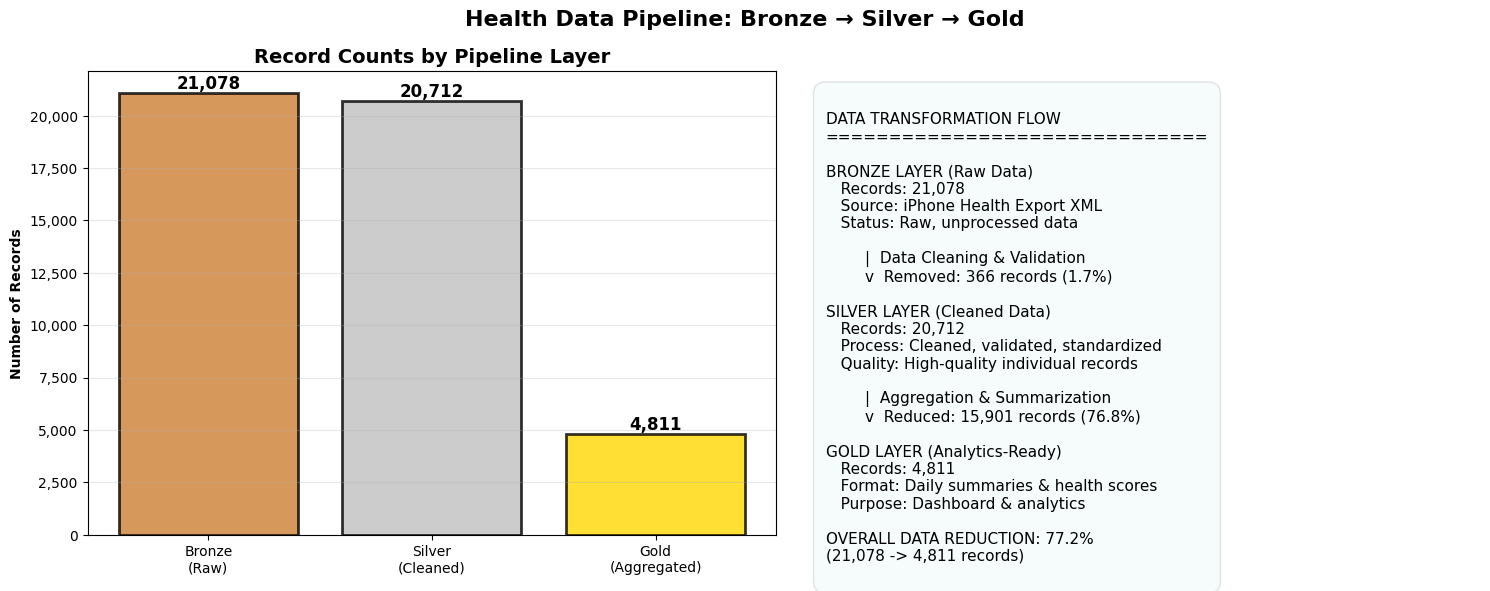

PIPELINE STATISTICS:
   • Bronze Layer: 21,078 records
   • Silver Layer: 20,712 records (1.7% reduction)
   • Gold Layer: 4,811 records (76.8% further reduction)

TRANSFORMATION EFFICIENCY:
   • Data cleaning removed: 366 invalid/duplicate records
   • Aggregation condensed: 15,901 records into daily summaries
   • Overall compression ratio: 4.4:1
   • Final dataset size: 77.2% smaller than raw input


In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Get record counts from each layer using correct table names
bronze_count = spark.sql("SELECT COUNT(*) as count FROM health_data.bronze.apple_health").collect()[0]['count']
silver_count = spark.sql("SELECT COUNT(*) as count FROM health_data.silver.apple_health").collect()[0]['count']
gold_count = spark.sql("SELECT COUNT(*) as count FROM health_data.gold.daily_health_summary").collect()[0]['count']

# Create summary DataFrame
pipeline_data = pd.DataFrame({
    'Layer': ['Bronze\n(Raw)', 'Silver\n(Cleaned)', 'Gold\n(Aggregated)'],
    'Record_Count': [bronze_count, silver_count, gold_count],
    'Colors': ['#CD7F32', '#C0C0C0', '#FFD700']  # Bronze, Silver, Gold colors
})

# Calculate data reduction percentages
bronze_to_silver_reduction = ((bronze_count - silver_count) / bronze_count) * 100
silver_to_gold_reduction = ((silver_count - gold_count) / silver_count) * 100
total_reduction = ((bronze_count - gold_count) / bronze_count) * 100

print("="*60)
print("DATA PIPELINE PROCESSING SUMMARY")
print("="*60)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Health Data Pipeline: Bronze → Silver → Gold', fontsize=16, fontweight='bold')

# 1. Bar Chart showing record counts
bars = ax1.bar(pipeline_data['Layer'], pipeline_data['Record_Count'], 
               color=pipeline_data['Colors'], alpha=0.8, edgecolor='black', linewidth=2)

# Add value labels on bars
for bar, count in zip(bars, pipeline_data['Record_Count']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=12)

ax1.set_title('Record Counts by Pipeline Layer', fontweight='bold', fontsize=14)
ax1.set_ylabel('Number of Records', fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Format y-axis with commas
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

# 2. Data Flow Visualization
ax2.axis('off')

# Create flow diagram without emojis
flow_text = f"""
DATA TRANSFORMATION FLOW
{'='*30}

BRONZE LAYER (Raw Data)
   Records: {bronze_count:,}
   Source: iPhone Health Export XML
   Status: Raw, unprocessed data

        |  Data Cleaning & Validation
        v  Removed: {bronze_count - silver_count:,} records ({bronze_to_silver_reduction:.1f}%)

SILVER LAYER (Cleaned Data)  
   Records: {silver_count:,}
   Process: Cleaned, validated, standardized
   Quality: High-quality individual records

        |  Aggregation & Summarization  
        v  Reduced: {silver_count - gold_count:,} records ({silver_to_gold_reduction:.1f}%)

GOLD LAYER (Analytics-Ready)
   Records: {gold_count:,}
   Format: Daily summaries & health scores
   Purpose: Dashboard & analytics

OVERALL DATA REDUCTION: {total_reduction:.1f}%
({bronze_count:,} -> {gold_count:,} records)
"""

ax2.text(0.05, 0.95, flow_text, transform=ax2.transAxes, fontsize=11,
         verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.8", facecolor='lightblue', alpha=0.1))

plt.tight_layout()
plt.show()

# Print detailed summary
print(f"PIPELINE STATISTICS:")
print(f"   • Bronze Layer: {bronze_count:,} records")
print(f"   • Silver Layer: {silver_count:,} records ({bronze_to_silver_reduction:.1f}% reduction)")
print(f"   • Gold Layer: {gold_count:,} records ({silver_to_gold_reduction:.1f}% further reduction)")
print(f"\nTRANSFORMATION EFFICIENCY:")
print(f"   • Data cleaning removed: {bronze_count - silver_count:,} invalid/duplicate records")
print(f"   • Aggregation condensed: {silver_count - gold_count:,} records into daily summaries")
print(f"   • Overall compression ratio: {bronze_count/gold_count:.1f}:1")
print(f"   • Final dataset size: {total_reduction:.1f}% smaller than raw input")

##  Health Data Analytics & Visualizations

Now we can use our Gold layer data to create insightful visualizations and analyses.

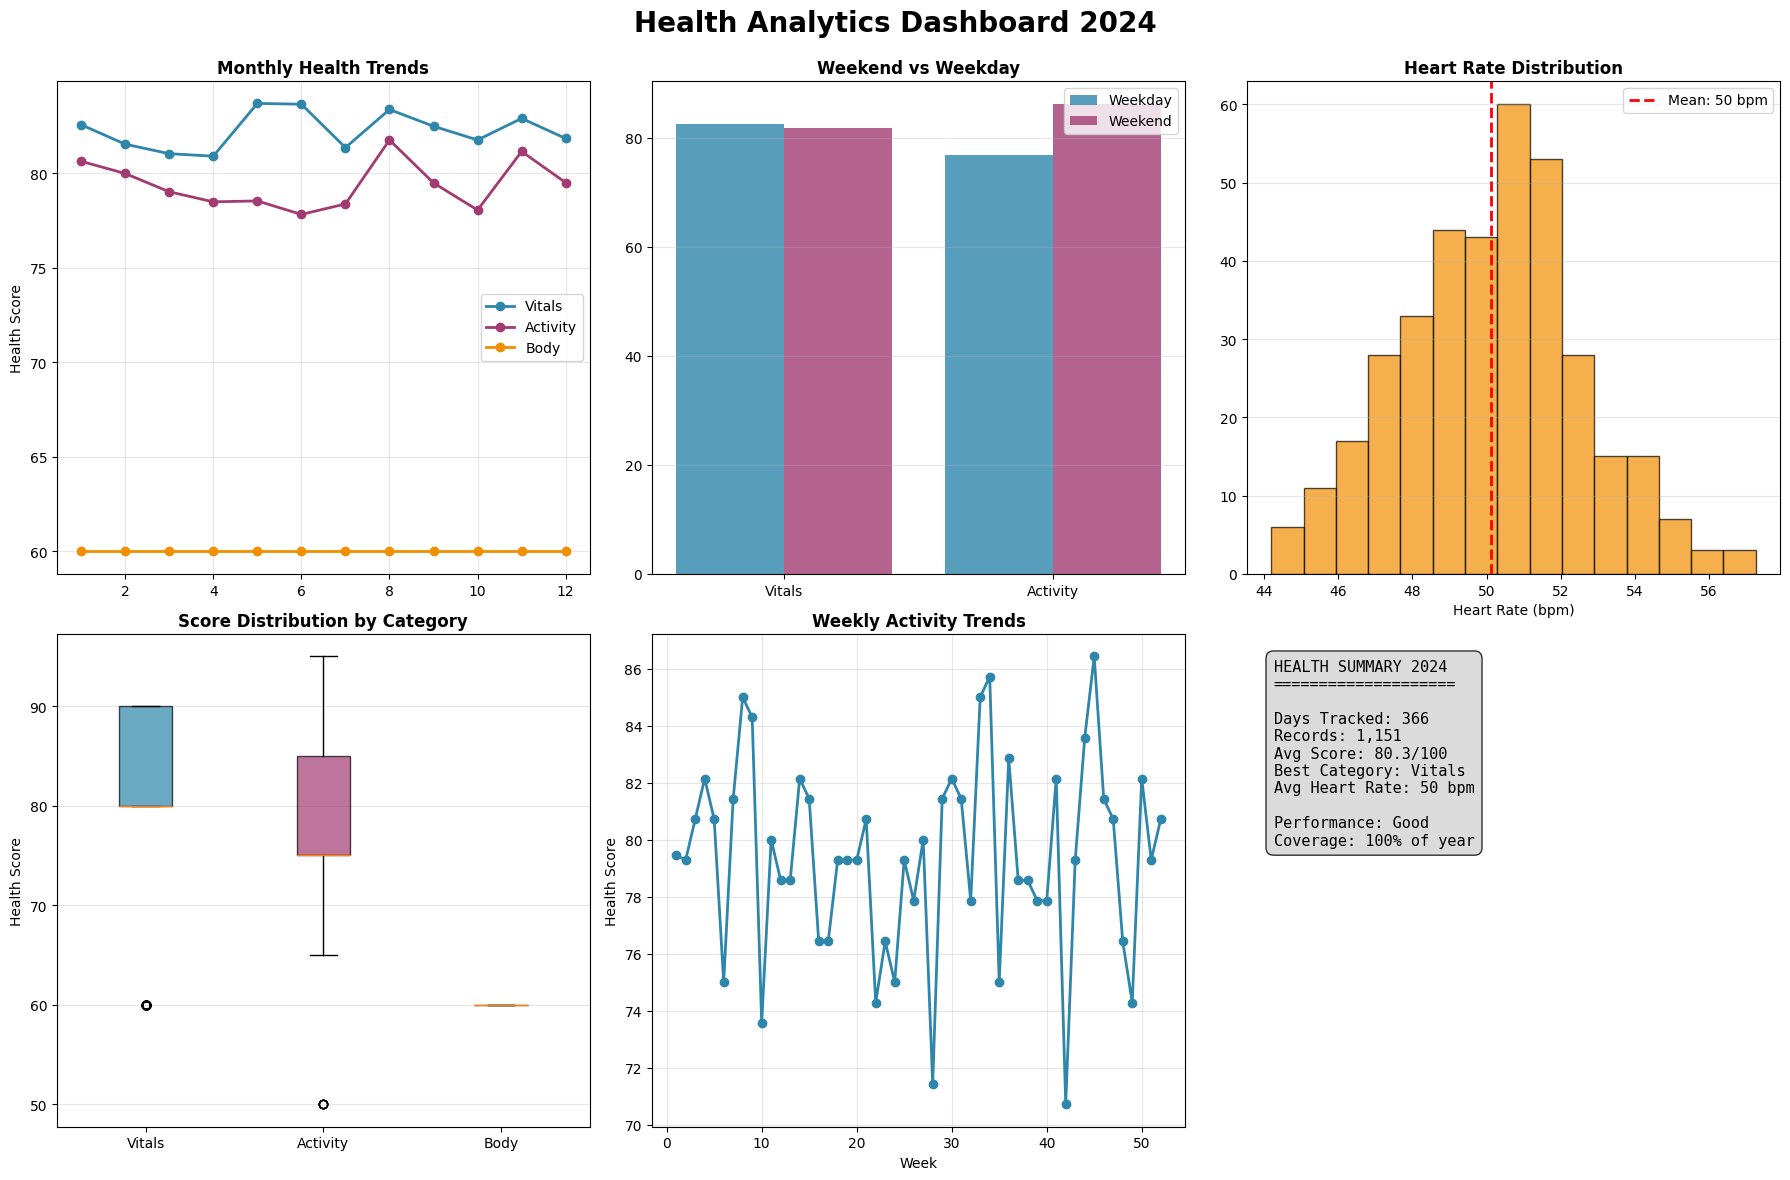

Dashboard complete! Analyzed 1,151 records from 366 days.


In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Simple styling
plt.style.use('default')
COLORS = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#85C1E9', '#90EE90']

# Get clean health data
health_summary = spark.sql("""
    SELECT activity_date, metric_name, metric_category, avg_value, health_score, 
           is_weekend, measurement_count, performance_trend, month
    FROM health_data.gold.daily_health_summary
    WHERE activity_date >= '2024-01-01' AND metric_category IN ('Vitals', 'Activity', 'Body')
      AND health_score IS NOT NULL AND avg_value IS NOT NULL
    ORDER BY activity_date
""").toPandas()

if len(health_summary) > 0:
    health_summary = health_summary.dropna(subset=['health_score', 'avg_value'])
    health_summary['activity_date'] = pd.to_datetime(health_summary['activity_date'])
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Health Analytics Dashboard 2024', fontsize=20, fontweight='bold', y=0.98)
    
    categories = health_summary['metric_category'].unique()
    
    # 1. Monthly Health Trends
    ax = axes[0, 0]
    for i, cat in enumerate(categories):
        monthly = health_summary[health_summary['metric_category'] == cat].groupby('month')['health_score'].mean()
        if len(monthly) > 0:
            ax.plot(monthly.index, monthly.values, marker='o', linewidth=2, 
                   label=cat, color=COLORS[i])
    ax.set_title('Monthly Health Trends', fontweight='bold')
    ax.set_ylabel('Health Score')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Weekend vs Weekday
    ax = axes[0, 1]
    weekend_data, weekday_data, cat_names = [], [], []
    for cat in categories:
        cat_data = health_summary[health_summary['metric_category'] == cat]
        weekend = cat_data[cat_data['is_weekend'] == True]['health_score'].mean()
        weekday = cat_data[cat_data['is_weekend'] == False]['health_score'].mean()
        if not pd.isna(weekend) and not pd.isna(weekday):
            weekend_data.append(weekend)
            weekday_data.append(weekday)
            cat_names.append(cat)
    
    if cat_names:
        x = np.arange(len(cat_names))
        ax.bar(x - 0.2, weekday_data, 0.4, label='Weekday', color=COLORS[0], alpha=0.8)
        ax.bar(x + 0.2, weekend_data, 0.4, label='Weekend', color=COLORS[1], alpha=0.8)
        ax.set_title('Weekend vs Weekday', fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(cat_names)
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
    
    # 3. Heart Rate Distribution
    ax = axes[0, 2]
    hr_data = health_summary[health_summary['metric_name'] == 'HeartRate']['avg_value'].dropna()
    if len(hr_data) > 0:
        ax.hist(hr_data, bins=15, alpha=0.7, color=COLORS[2], edgecolor='black')
        ax.axvline(hr_data.mean(), color='red', linestyle='--', linewidth=2, 
                  label=f'Mean: {hr_data.mean():.0f} bpm')
        ax.set_title('Heart Rate Distribution', fontweight='bold')
        ax.set_xlabel('Heart Rate (bpm)')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
    else:
        ax.text(0.5, 0.5, 'No Heart Rate Data', ha='center', va='center', transform=ax.transAxes)
    
    # 4. Health Score Distribution by Category
    ax = axes[1, 0]
    cat_scores = [health_summary[health_summary['metric_category'] == cat]['health_score'].dropna() 
                  for cat in categories]
    cat_scores = [scores for scores in cat_scores if len(scores) > 0]
    
    if cat_scores:
        bp = ax.boxplot(cat_scores, labels=categories[:len(cat_scores)], patch_artist=True)
        for patch, color in zip(bp['boxes'], COLORS):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        ax.set_title('Score Distribution by Category', fontweight='bold')
        ax.set_ylabel('Health Score')
        ax.grid(True, alpha=0.3, axis='y')
    
    # 5. Weekly Activity Trends
    ax = axes[1, 1]
    activity_data = health_summary[health_summary['metric_category'] == 'Activity'].copy()
    if len(activity_data) > 0:
        activity_data['week'] = activity_data['activity_date'].dt.isocalendar().week
        weekly = activity_data.groupby('week')['health_score'].mean().dropna()
        if len(weekly) > 1:
            ax.plot(weekly.index, weekly.values, color=COLORS[0], linewidth=2, marker='o')
            ax.set_title('Weekly Activity Trends', fontweight='bold')
            ax.set_xlabel('Week')
            ax.set_ylabel('Health Score')
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'Insufficient Activity Data', ha='center', va='center', transform=ax.transAxes)
    else:
        ax.text(0.5, 0.5, 'No Activity Data', ha='center', va='center', transform=ax.transAxes)
    
    # 6. Summary Stats
    ax = axes[1, 2]
    ax.axis('off')
    
    total_days = len(health_summary['activity_date'].unique())
    avg_score = health_summary['health_score'].mean()
    best_cat = health_summary.groupby('metric_category')['health_score'].mean().idxmax()
    hr_avg = health_summary[health_summary['metric_name'] == 'HeartRate']['avg_value'].mean()
    
    summary = f"""HEALTH SUMMARY 2024
{'='*20}

Days Tracked: {total_days}
Records: {len(health_summary):,}
Avg Score: {avg_score:.1f}/100
Best Category: {best_cat}
Avg Heart Rate: {hr_avg:.0f} bpm

Performance: {'Excellent' if avg_score >= 85 else 'Good' if avg_score >= 75 else 'Fair'}
Coverage: {(total_days/365)*100:.0f}% of year"""
    
    ax.text(0.05, 0.95, summary, transform=ax.transAxes, fontsize=11, 
           verticalalignment='top', fontfamily='monospace',
           bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()
    
    print(f"Dashboard complete! Analyzed {len(health_summary):,} records from {total_days} days.")

else:
    print("No health data found.")

##  Advanced SQL Analytics on the Gold Layer

Demonstrate powerful SQL analytics capabilities on our well-structured Gold layer data.


In [0]:
%sql
-- Executive Health Summary: Key insights at a glance
SELECT 
    '🏥 OVERALL HEALTH REPORT' AS section,
    '' AS metric,
    '' AS value,
    '' AS insight

UNION ALL

SELECT 
    'Health Score Overview',
    'Overall Health Score',
    ROUND(AVG(health_score), 1) || '/100',
    CASE 
        WHEN AVG(health_score) >= 90 THEN '🟢 Excellent - Following medical guidelines'
        WHEN AVG(health_score) >= 80 THEN '🟡 Good - Room for minor improvements'
        WHEN AVG(health_score) >= 70 THEN '🟠 Fair - Consider lifestyle changes'
        ELSE '🔴 Needs attention - Consult healthcare provider'
    END
FROM health_data.gold.daily_health_summary
WHERE activity_date >= DATE_SUB(CURRENT_DATE(), 90)

UNION ALL

SELECT 
    'Activity Performance',
    'Step Count Performance',
    ROUND(AVG(CASE WHEN metric_name = 'StepCount' THEN health_score END), 1) || '/100',
    CASE 
        WHEN AVG(CASE WHEN metric_name = 'StepCount' THEN avg_value END) >= 10000 THEN '🟢 Meeting CDC recommendations (10k+ steps)'
        WHEN AVG(CASE WHEN metric_name = 'StepCount' THEN avg_value END) >= 8000 THEN '🟡 Good activity level (8k+ steps)'
        WHEN AVG(CASE WHEN metric_name = 'StepCount' THEN avg_value END) >= 6000 THEN '🟠 Moderate activity (6k+ steps)'
        ELSE '🔴 Below recommended activity levels'
    END
FROM health_data.gold.daily_health_summary
WHERE metric_name = 'StepCount' AND activity_date >= DATE_SUB(CURRENT_DATE(), 90)

UNION ALL

SELECT 
    'Cardiovascular Health',
    'Heart Rate Assessment',
    ROUND(AVG(CASE WHEN metric_name = 'HeartRate' THEN health_score END), 1) || '/100',
    CASE 
        WHEN AVG(CASE WHEN metric_name = 'HeartRate' THEN avg_value END) BETWEEN 60 AND 80 THEN '🟢 Optimal heart rate (AHA guidelines)'
        WHEN AVG(CASE WHEN metric_name = 'HeartRate' THEN avg_value END) BETWEEN 50 AND 100 THEN '🟡 Normal range for your fitness level'
        ELSE '🟠 Consider discussing with healthcare provider'
    END
FROM health_data.gold.daily_health_summary
WHERE metric_name = 'HeartRate' AND activity_date >= DATE_SUB(CURRENT_DATE(), 90)

UNION ALL

SELECT 
    'Lifestyle Patterns',
    'Weekend vs Weekday',
    ROUND(
        AVG(CASE WHEN is_weekend THEN health_score END) - 
        AVG(CASE WHEN NOT is_weekend THEN health_score END), 1
    ) || ' point difference',
    CASE 
        WHEN AVG(CASE WHEN is_weekend THEN health_score END) > AVG(CASE WHEN NOT is_weekend THEN health_score END) + 2 
        THEN '🟢 More active on weekends - good work-life balance'
        WHEN AVG(CASE WHEN NOT is_weekend THEN health_score END) > AVG(CASE WHEN is_weekend THEN health_score END) + 2 
        THEN '🟡 More active on weekdays - consider weekend activities'
        ELSE '🟢 Consistent activity pattern throughout week'
    END
FROM health_data.gold.daily_health_summary
WHERE activity_date >= DATE_SUB(CURRENT_DATE(), 90)

UNION ALL

SELECT 
    'Data Quality',
    'Tracking Consistency',
    COUNT(DISTINCT activity_date) || ' days in last 90',
    CASE 
        WHEN COUNT(DISTINCT activity_date) >= 75 THEN '🟢 Excellent tracking consistency'
        WHEN COUNT(DISTINCT activity_date) >= 60 THEN '🟡 Good tracking consistency'
        WHEN COUNT(DISTINCT activity_date) >= 30 THEN '🟠 Moderate tracking - room for improvement'
        ELSE '🔴 Limited tracking - consider more consistent monitoring'
    END
FROM health_data.gold.daily_health_summary
WHERE activity_date >= DATE_SUB(CURRENT_DATE(), 90)

ORDER BY 
    CASE section 
        WHEN '🏥 OVERALL HEALTH REPORT' THEN 1
        WHEN 'Health Score Overview' THEN 2
        WHEN 'Activity Performance' THEN 3
        WHEN 'Cardiovascular Health' THEN 4
        WHEN 'Lifestyle Patterns' THEN 5
        WHEN 'Data Quality' THEN 6
    END;

section,metric,value,insight
🏥 OVERALL HEALTH REPORT,,,
Health Score Overview,Overall Health Score,null,🔴 Needs attention - Consult healthcare provider
Activity Performance,Step Count Performance,null,🔴 Below recommended activity levels
Cardiovascular Health,Heart Rate Assessment,null,🟠 Consider discussing with healthcare provider
Lifestyle Patterns,Weekend vs Weekday,null,🟢 Consistent activity pattern throughout week
Data Quality,Tracking Consistency,0 days in last 90,🔴 Limited tracking - consider more consistent monitoring


##  Unity Catalog Management

Unity Catalog provides centralized governance and security for your data assets.

In [0]:
%sql
-- Creating a view for easier access
CREATE OR REPLACE VIEW health_data.gold.vitals_summary AS
SELECT
    activity_date,
    metric_name,
    avg_value,
    min_value,
    max_value,
    health_score,
    is_weekend
FROM health_data.gold.daily_health_summary
WHERE metric_category = 'Vitals'

In [0]:
%sql
    -- Example of setting up access control (commented out as this is a tutorial)
    -- GRANT SELECT ON TABLE health_data.gold.vitals_summary TO `analysts`
    -- GRANT SELECT ON SCHEMA health_data.gold TO `data_scientists`
    -- GRANT MODIFY ON SCHEMA health_data.bronze TO `data_engineers`
    
    -- Just showing these commands for educational purposes
    SHOW TABLES IN health_data.gold


database,tableName,isTemporary
gold,daily_health_summary,false
gold,fitness_mart,false
gold,vitals_summary,false
,_sqldf,true
,raw_health_records,true
